In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from mpl_toolkits.basemap import Basemap
from pylab import rcParams
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


In [5]:
file_path = 'weather.csv'
df = pd.read_csv(file_path)
df.sample(5)

Stn_Name     Lat     Long Prov    Tm  DwTm    D    Tx  DwTx  \
908        PORT COLBORNE  42.883  -79.250   ON -10.9   2.0 -8.0   0.0   2.0   
545   SEVEN PERSONS AGDM  49.917 -110.917   AB  -5.6   0.0  NaN  14.9   0.0   
755      BERENS RIVER CS  52.360  -97.022   MB -23.3   0.0 -7.1  -5.1   0.0   
280               FARO A  62.207 -133.373   YT -16.2   0.0 -0.8   6.8   0.0   
1234        BRIER ISLAND  44.286  -66.347   NS  -6.3   0.0  NaN   4.4   0.0   

        Tn  ...   DwP    P%N   S_G    Pd  BS  DwBS  BS%     HDD  CDD   Stn_No  
908  -26.0  ...   2.0    NaN  20.0  17.0 NaN   NaN  NaN   751.2  0.0  6136606  
545  -23.6  ...   1.0    NaN   NaN   3.0 NaN   NaN  NaN   659.4  0.0  3035845  
755  -38.6  ...   0.0  130.0  17.0   4.0 NaN   NaN  NaN  1156.8  0.0  5030203  
280  -44.8  ...   0.0   36.0  35.0   1.0 NaN   NaN  NaN   958.0  0.0  2100517  
1234 -17.1  ...  10.0    NaN   NaN   5.0 NaN   NaN  NaN   681.0  0.0  8200604  

[5 rows x 25 columns]

In [6]:
df = df[pd.notnull(df['Tm'])]
df = df.reset_index(drop=True)

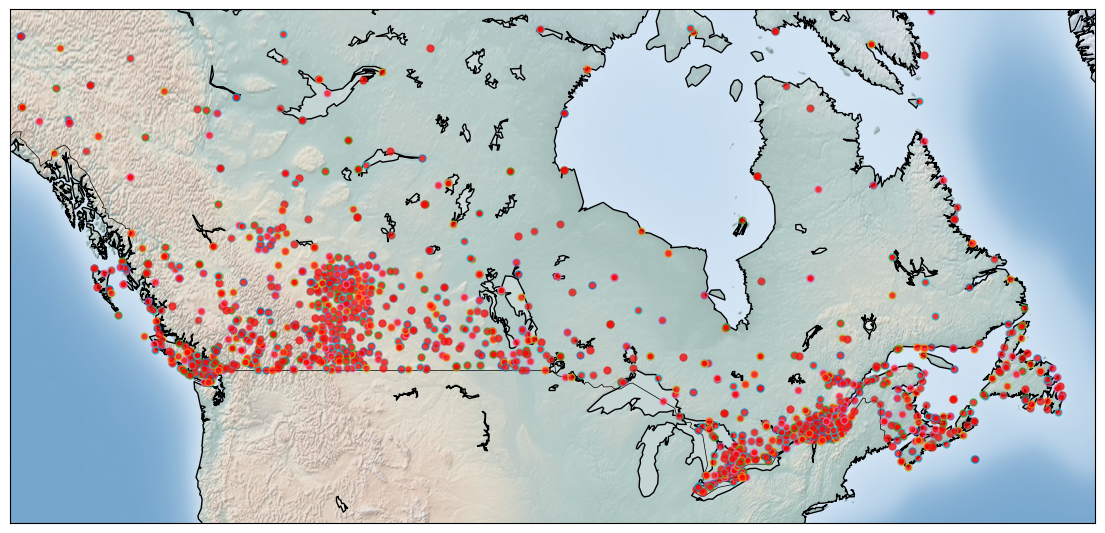

In [7]:
def plot_map(df):
    rcParams['figure.figsize'] = (14, 10)

    llon = -140
    ulon = -50
    llat = 40
    ulat = 65

    df = df[(df['Long'] > llon) & (df['Long'] < ulon) & (df['Lat'] > llat) & (df['Lat'] < ulat)]

    my_map = Basemap(
        projection='merc',
        resolution='l',
        area_thresh=1000.0,
        llcrnrlon=llon,
        llcrnrlat=llat,  # min longitude (llcrnrlon) and latitude (llcrnrlat)
        urcrnrlon=ulon,
        urcrnrlat=ulat
    )  # max longitude (urcrnrlon) and latitude (urcrnrlat)

    my_map.drawcoastlines()
    my_map.drawcountries()
    # my_map.drawmapboundary()
    my_map.fillcontinents(color='white', alpha=0.3)
    my_map.shadedrelief()

    # To collect data based on stations

    xs, ys = my_map(np.asarray(df.Long), np.asarray(df.Lat))
    df['xm'] = xs.tolist()
    df['ym'] = ys.tolist()

    # Visualization1
    for index, row in df.iterrows():
        #   x,y = my_map(row.Long, row.Lat)
        my_map.plot(
            row.xm,
            row.ym,
            markerfacecolor=([1, 0, 0]),
            marker='o',
            markersize=5,
            alpha=0.75
        )

    # plt.text(x,y,stn)
    plt.show()

    return ((llon, ulon, llat, ulat), df)

(llon, ulon, llat, ulat), df = plot_map(df.copy())


In [6]:
sklearn.utils.check_random_state(1000)


RandomState(MT19937) at 0x1EF6C4F7040

In [8]:
Clus_dataSet = df[['xm', 'ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)

scaler = StandardScaler()
Clus_dataSet = scaler.fit_transform(Clus_dataSet)

Clus_dataSet

array([[-1.16833902, -0.33176141],
       [-1.18518021, -0.35499148],
       [-1.18169137, -0.35394619],
       ...,
       [ 1.46577713,  1.86125634],
       [ 1.64788589,  0.95789607],
       [ 1.2814717 ,  0.53978899]])

In [9]:
db = DBSCAN(eps=0.15, min_samples=10)
db.fit(Clus_dataSet)

DBSCAN(eps=0.15, min_samples=10)

In [9]:
print(set(db.labels_)) # unique clusters
db.labels_

{0, 1, 2, 3, 4, -1}


array([ 0,  0,  0, ..., -1, -1, -1], dtype=int64)

In [10]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True,  True, ..., False, False, False])

In [11]:
labels = db.labels_
df['Clus_Db'] = labels
df[['Clus_Db']].head()

Clus_Db
0        0
1        0
2        0
3        0
4        0

In [12]:
# Number of clusters in labels, ignoring noise if present.
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)

# Remove repetition in labels by turning it into a set.
clusterNum = len(set(labels))

# A sample of clusters
df[['Stn_Name', 'Tx', 'Tm', 'Clus_Db']].head(5)

Stn_Name    Tx   Tm  Clus_Db
0               CHEMAINUS  13.5  8.2        0
1  COWICHAN LAKE FORESTRY  15.0  7.0        0
2           LAKE COWICHAN  16.0  6.8        0
3     DUNCAN KELVIN CREEK  14.5  7.7        0
4       ESQUIMALT HARBOUR  13.1  8.8        0

In [13]:
set(labels)


{-1, 0, 1, 2, 3, 4}

Cluster 0, Avg Temp: -5.538747553816046
Cluster 1, Avg Temp: 1.9526315789473685
Cluster 2, Avg Temp: -9.195652173913045
Cluster 3, Avg Temp: -15.300833333333333
Cluster 4, Avg Temp: -7.769047619047619


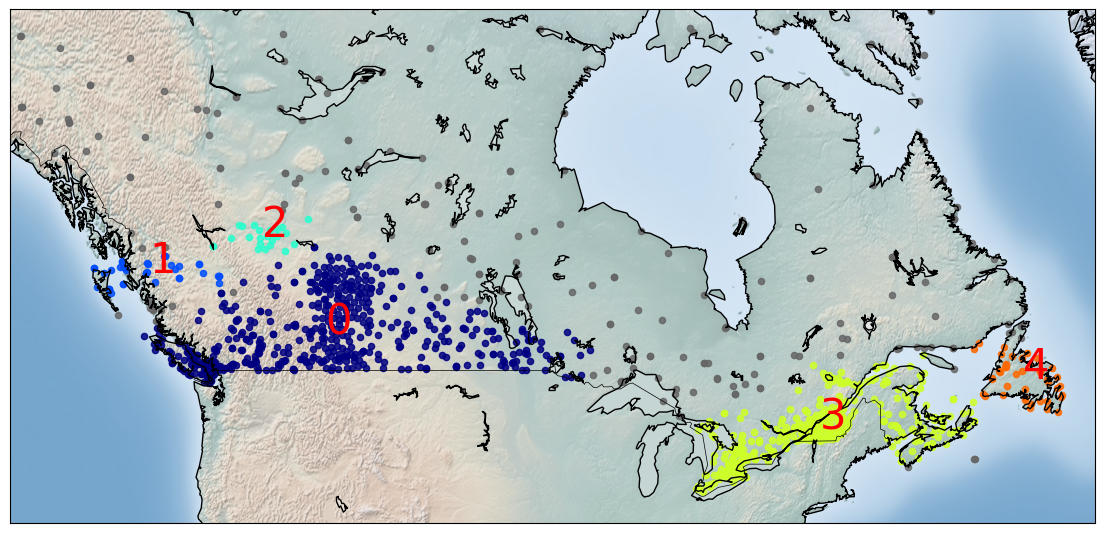

In [18]:
# Visualisation of clusters based on location
def plot_clusters_map(llon, ulon, llat, ulat, labels):
    rcParams['figure.figsize'] = (14, 10)

    my_map = Basemap(
        projection='merc',
        resolution='l',
        area_thresh=1000.0,
        llcrnrlon=llon,
        llcrnrlat=llat,  # min longitude (llcrnrlon) and latitude (llcrnrlat)
        urcrnrlon=ulon,
        urcrnrlat=ulat
    )  # max longitude (urcrnrlon) and latitude (urcrnrlat)

    my_map.drawcoastlines()
    my_map.drawcountries()
    #my_map.drawmapboundary()
    my_map.fillcontinents(color='white', alpha=0.3)
    my_map.shadedrelief()

    # To create a color map
    colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

    #Visualization1
    for clust_number in set(labels):
      
        c = ([0.4, 0.4, 0.4]) if clust_number == -1 else colors[int(clust_number)]

        clust_set = df[df.Clus_Db == clust_number]
        my_map.scatter(
            clust_set.xm, clust_set.ym, color=c, marker='o', s=20, alpha=0.85
        )
        if clust_number != -1:
            cenx = np.mean(clust_set.xm)
            ceny = np.mean(clust_set.ym)
            plt.text(
                cenx,
                ceny,
                str(clust_number),
                fontsize=30,
                color='red',
                  )
            print(
                "Cluster " + str(clust_number) + ', Avg Temp: ' +
                str(np.mean(clust_set.Tm))
            )


plot_clusters_map(llon, ulon, llat, ulat, labels)

In [19]:
# In this section we re-run DBSCAN, but this time on a 5-dimensional dataset
Clus_dataSet = df[['xm', 'ym', 'Tx', 'Tm', 'Tn']]

In [20]:
# Data wrangling 
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

In [21]:
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)

In [22]:
# Lets Replace all elements with 'True' in core_samples_mask that are in the cluster, 'False' if the points are outliers.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

labels = db.labels_
df['Clus_Db'] = labels

# Number of clusters in labels, ignoring noise if present.
realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)

# Remove repetition in labels by turning it into a set.
clusterNum = len(set(labels))

# A sample of clusters
df[['Stn_Name', 'Tx', 'Tm', 'Clus_Db']].head(5)

Stn_Name    Tx   Tm  Clus_Db
0               CHEMAINUS  13.5  8.2        0
1  COWICHAN LAKE FORESTRY  15.0  7.0        0
2           LAKE COWICHAN  16.0  6.8        0
3     DUNCAN KELVIN CREEK  14.5  7.7        0
4       ESQUIMALT HARBOUR  13.1  8.8        0

Cluster 0, Avg Temp: 6.221192052980132
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882344
Cluster 3, Avg Temp: -13.87720930232558
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398496
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


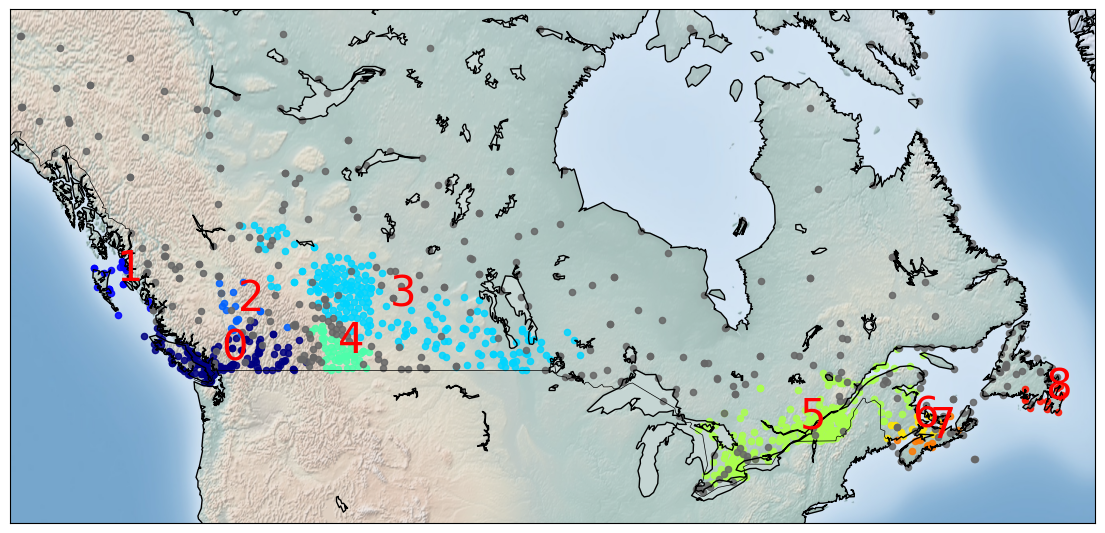

In [23]:
plot_clusters_map(llon, ulon, llat, ulat, labels)


In [24]:
def model(df, dataset, eps=0.15, min_samples=10):
    dataset = np.nan_to_num(dataset)
    
    # Scaling the dataset
    dataset = StandardScaler().fit_transform(dataset)
    
    # Computer DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(dataset)
    
    # Distinguish outliers

    # Lets Replace all elements with 'True' in core_samples_mask that are in the cluster, 'False' if the points are outliers.
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_
    df['Clus_Db'] = labels

    # Number of clusters in labels, ignoring noise if present.
    real_cluster_num = len(set(labels)) - (1 if -1 in labels else 0)

    # Remove repetition in labels by turning it into a set.
    cluster_num = len(set(labels))

    # Number of clusters in labels, ignoring noise if present.
    real_cluster_num = len(set(labels)) - (1 if -1 in labels else 0)
    
    print(f'Unique clusters: {set(labels)}')
    
    return (df, dataset, labels, core_samples_mask, db)

Unique clusters: {0, 1, 2, 3, 4, -1}
Cluster 0, Avg Temp: -5.538747553816046
Cluster 1, Avg Temp: 1.9526315789473685
Cluster 2, Avg Temp: -9.195652173913045
Cluster 3, Avg Temp: -15.300833333333333
Cluster 4, Avg Temp: -7.769047619047619


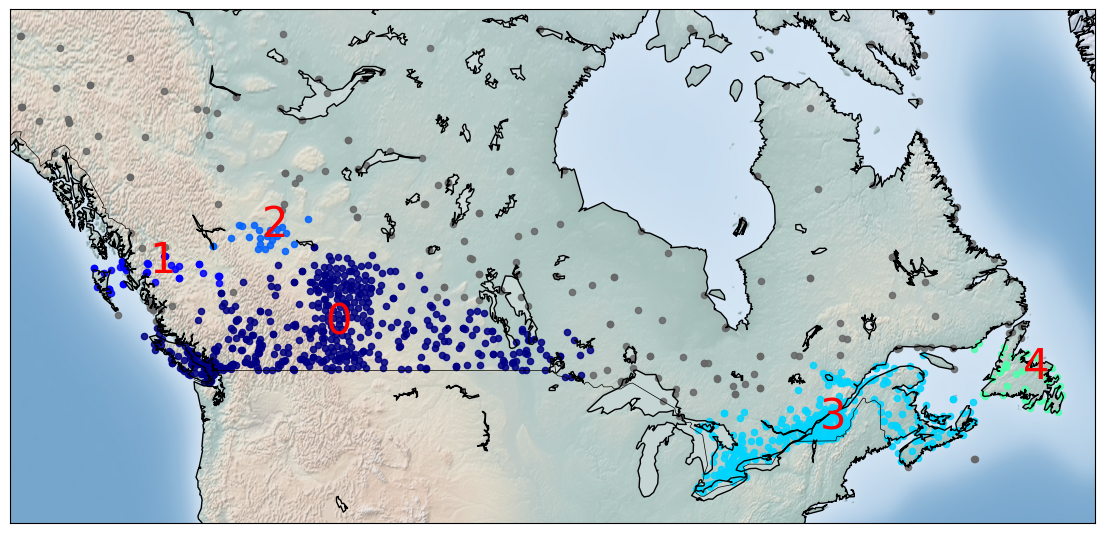

In [25]:
dataset = df[['xm', 'ym']]
_, _, labels, _, _ = model(df, dataset)
plot_clusters_map(llon, ulon, llat, ulat, labels)